In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pyarrow

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb  # ML algorithm for forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Error metrics

In [2]:
import time

# Record the start time
start_time = time.time()

Referenced from: https://github.com/jpsam07/skyline-hospital-time-series-forecasting-with-xgboost?tab=readme-ov-file#data-collection

In [3]:
filepath = 'sample-data/term_dates_parking.csv' # change as needed

df = pd.read_csv(filepath)

df.head()


,Timestamp,North,West,Rose,Health Sciences,Fraser,Thunderbird,University Lot Blvd,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,snow_1h,term_date,is_holiday
0,2018-09-06 10:00:00,951,1016,476,913,556,939,-1,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,NaN,False,False
1,2018-09-06 11:00:00,922,1160,609,972,707,1050,-1,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,NaN,False,False
2,2018-09-06 12:00:00,833,1206,659,963,724,1072,-1,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,NaN,False,False
3,2018-09-06 13:00:00,851,1168,695,953,719,1094,-1,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,NaN,False,False
4,2018-09-06 14:00:00,857,1220,710,963,727,1069,-1,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,NaN,False,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36158 entries, 0 to 36157
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            36158 non-null  object 
 1   North                36158 non-null  int64  
 2   West                 36158 non-null  int64  
 3   Rose                 36158 non-null  int64  
 4   Health Sciences      36158 non-null  int64  
 5   Fraser               36158 non-null  int64  
 6   Thunderbird          36158 non-null  int64  
 7   University Lot Blvd  36158 non-null  int64  
 8   temp                 36158 non-null  float64
 9   visibility           32468 non-null  float64
 10  dew_point            36158 non-null  float64
 11  feels_like           36158 non-null  float64
 12  pressure             36158 non-null  int64  
 13  humidity             36158 non-null  int64  
 14  wind_speed           36158 non-null  float64
 15  clouds_all           36158 non-null 

In [5]:
df.rename(columns={'Timestamp': 'date'}, inplace=True)
df = df.set_index('date')
df

,North,West,Rose,Health Sciences,Fraser,Thunderbird,University Lot Blvd,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,snow_1h,term_date,is_holiday
date,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,951,1016,476,913,556,939,-1,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,NaN,False,False
2018-09-06 11:00:00,922,1160,609,972,707,1050,-1,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,NaN,False,False
2018-09-06 12:00:00,833,1206,659,963,724,1072,-1,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,NaN,False,False
2018-09-06 13:00:00,851,1168,695,953,719,1094,-1,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,NaN,False,False
2018-09-06 14:00:00,857,1220,710,963,727,1069,-1,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,72,232,154,172,119,217,64,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,NaN,False,False
2024-03-05 20:00:00,10,146,100,91,70,164,43,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,NaN,False,False
2024-03-05 21:00:00,0,88,44,62,43,121,34,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,NaN,False,False


In [6]:
# Convert sensor columns to numeric (in case they are not already)
# df['sensor'] = df.iloc[:, 0:10].mean(axis=1)
#df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Calculate the average across sensor columns
# df['sensor'] = df.iloc[:, 1:].mean(axis=1)

# Drop the individual sensor columns
# df.drop(columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], inplace=True)

# Display the updated DataFrame
parking_lot_to_predict = 'North'
df.rename(columns={parking_lot_to_predict: 'Occupancy'}, inplace=True)

parking_lots = ['North','West', 'Rose', 'Health Sciences', 'Fraser', 'Thunderbird', 'University Lot Blvd']

parking_lots.remove(parking_lot_to_predict)
df.drop(columns=parking_lots, inplace=True)
print(df.head())


                     Occupancy   temp  visibility  dew_point  feels_like  \
date                                                                       
2018-09-06 10:00:00        951  14.59     10000.0      10.21       14.06   
2018-09-06 11:00:00        922  14.01     10000.0       9.85       13.45   
2018-09-06 12:00:00        833  14.16     10000.0      10.58       13.69   
2018-09-06 13:00:00        851  13.85     10000.0       9.70       13.28   
2018-09-06 14:00:00        857  13.96     10000.0       9.41       13.34   

                     pressure  humidity  wind_speed  clouds_all  rain_1h  \
date                                                                       
2018-09-06 10:00:00      1015        75        1.03          20      NaN   
2018-09-06 11:00:00      1016        76        0.00          40      NaN   
2018-09-06 12:00:00      1016        79        2.10          75      NaN   
2018-09-06 13:00:00      1016        76        2.10          30      NaN   
2018-09-06 

In [7]:
old_df = df
# Calculate the 95th percentile of the 'Occupancy' column
threshold = df['Occupancy'].quantile(1)

# Filter the DataFrame to exclude values above the threshold
df = df[df['Occupancy'] <= threshold]

# Display the filtered DataFrame
print(df)

                     Occupancy   temp  visibility  dew_point  feels_like  \
date                                                                       
2018-09-06 10:00:00        951  14.59     10000.0      10.21       14.06   
2018-09-06 11:00:00        922  14.01     10000.0       9.85       13.45   
2018-09-06 12:00:00        833  14.16     10000.0      10.58       13.69   
2018-09-06 13:00:00        851  13.85     10000.0       9.70       13.28   
2018-09-06 14:00:00        857  13.96     10000.0       9.41       13.34   
...                        ...    ...         ...        ...         ...   
2024-03-05 19:00:00         72   3.21     10000.0      -0.53        1.22   
2024-03-05 20:00:00         10   4.18     10000.0      -1.41        0.78   
2024-03-05 21:00:00          0   4.17     10000.0      -1.06        0.49   
2024-03-05 22:00:00          1   4.57     10000.0      -1.45        1.26   
2024-03-05 23:00:00          0   4.68     10000.0      -1.55        2.46   

           

In [8]:
df = df.copy()
df['date'] = pd.to_datetime(df.index)
df['day_of_week'] = df['date'].dt.dayofweek
print(df.head())

print(df.tail())

                     Occupancy   temp  visibility  dew_point  feels_like  \
date                                                                       
2018-09-06 10:00:00        951  14.59     10000.0      10.21       14.06   
2018-09-06 11:00:00        922  14.01     10000.0       9.85       13.45   
2018-09-06 12:00:00        833  14.16     10000.0      10.58       13.69   
2018-09-06 13:00:00        851  13.85     10000.0       9.70       13.28   
2018-09-06 14:00:00        857  13.96     10000.0       9.41       13.34   

                     pressure  humidity  wind_speed  clouds_all  rain_1h  \
date                                                                       
2018-09-06 10:00:00      1015        75        1.03          20      NaN   
2018-09-06 11:00:00      1016        76        0.00          40      NaN   
2018-09-06 12:00:00      1016        79        2.10          75      NaN   
2018-09-06 13:00:00      1016        76        2.10          30      NaN   
2018-09-06 

<Axes: xlabel='day_of_week'>

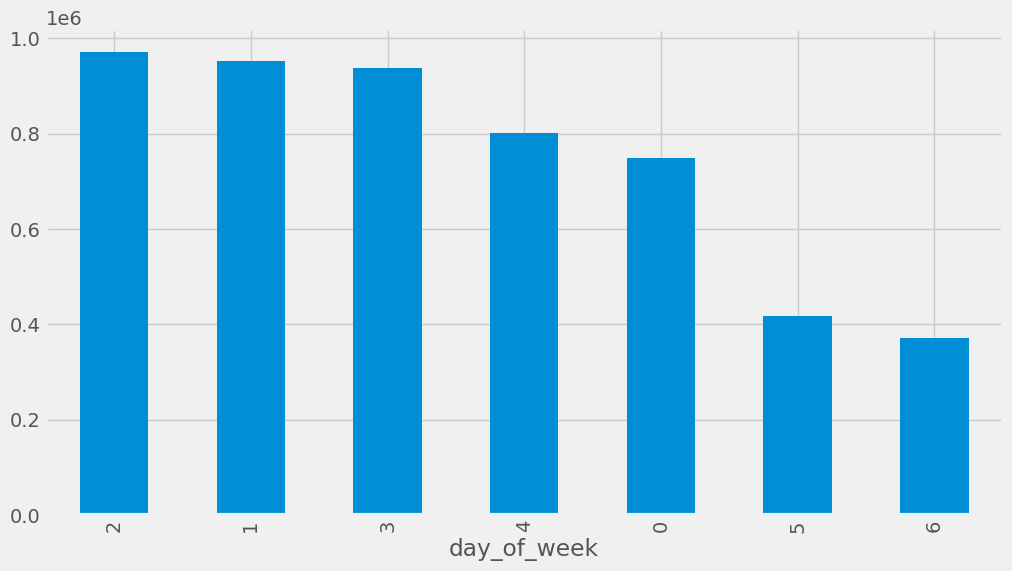

In [9]:
df.groupby('day_of_week')['Occupancy'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))


In [10]:
import pandas as pd

# Ensure the date column is in datetime format (assuming the date column is named 'date')
df['date'] = pd.to_datetime(df['date'])

# Define the date range (assuming the year spans across December to January)
start_date = pd.to_datetime('2023-12-20')
end_date = pd.to_datetime('2024-01-05')

# Filter the data
filtered_df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Display the filtered data
filtered_df


,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,snow_1h,term_date,is_holiday,date,day_of_week
date,,,,,,,,,,,,,,,
2023-12-20 00:00:00,0,9.82,10000.0,9.21,8.24,1003,96,3.09,100,0.59,NaN,False,False,2023-12-20 00:00:00,2
2023-12-20 01:00:00,3,9.54,9656.0,8.93,7.63,1004,96,3.60,100,0.25,NaN,False,False,2023-12-20 01:00:00,2
2023-12-20 02:00:00,0,9.48,9656.0,9.18,7.31,1005,98,4.12,100,1.53,NaN,False,False,2023-12-20 02:00:00,2
2023-12-20 03:00:00,1,9.45,4828.0,9.00,7.52,1005,97,3.60,100,0.76,NaN,False,False,2023-12-20 03:00:00,2
2023-12-20 04:00:00,3,9.48,2414.0,9.18,7.83,1006,98,3.09,100,1.02,NaN,False,False,2023-12-20 04:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04 20:00:00,7,6.13,8047.0,5.69,3.18,1017,97,4.12,75,1.02,NaN,False,False,2024-01-04 20:00:00,3
2024-01-04 21:00:00,0,6.66,10000.0,6.37,4.13,1017,98,3.58,75,0.46,NaN,False,False,2024-01-04 21:00:00,3
2024-01-04 22:00:00,1,7.30,NaN,6.71,4.67,1018,96,4.02,64,0.29,NaN,False,False,2024-01-04 22:00:00,3


In [11]:
filtered_df.to_csv("holidays_check.csv")

In [12]:
from statsmodels.tsa.seasonal import STL

In [13]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Assuming 'Occupancy' is the column containing the Occupancy data
traffic_series = df['Occupancy']

# Step 1: Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Step 2: Extract 'Occupancy' as a pandas Series
traffic_series = df['Occupancy']



In [14]:

# Step 3: Convert the data type of the Series to numeric (if needed)
traffic_series = pd.to_numeric(traffic_series, errors='coerce')

traffic_series.head()




date
2018-09-06 10:00:00    951
2018-09-06 11:00:00    922
2018-09-06 12:00:00    833
2018-09-06 13:00:00    851
2018-09-06 14:00:00    857
Name: Occupancy, dtype: int64

In [15]:
traffic_series.tail()

date
2024-03-05 19:00:00    72
2024-03-05 20:00:00    10
2024-03-05 21:00:00     0
2024-03-05 22:00:00     1
2024-03-05 23:00:00     0
Name: Occupancy, dtype: int64

In [16]:
'''
# Perform STL decomposition
# stl = STL(traffic_series, seasonal= 24 * 7)  # Assuming hourly data with weekly seasonality
result = stl.fit()

print(stl, result, sep='\n')
'''

"\n# Perform STL decomposition\n# stl = STL(traffic_series, seasonal= 24 * 7)  # Assuming hourly data with weekly seasonality\nresult = stl.fit()\n\nprint(stl, result, sep='\n')\n"

In [17]:
'''
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=3)

# Observed component
result.observed.plot(ax=ax[0], legend=False)
ax[0].set_title('Observed')

# Trend component
result.trend.plot(ax=ax[1], legend=False)
ax[1].set_title('Trend')

# Seasonal component
result.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_title('Seasonal')

# Residual component
result.resid.plot(ax=ax[3], legend=False)
ax[3].set_title('Residual')

# Show plot
plt.show()
'''

"\n# Plot the components\nfig, ax = plt.subplots(4, 1, figsize=(12, 8))\nplt.subplots_adjust(hspace=3)\n\n# Observed component\nresult.observed.plot(ax=ax[0], legend=False)\nax[0].set_title('Observed')\n\n# Trend component\nresult.trend.plot(ax=ax[1], legend=False)\nax[1].set_title('Trend')\n\n# Seasonal component\nresult.seasonal.plot(ax=ax[2], legend=False)\nax[2].set_title('Seasonal')\n\n# Residual component\nresult.resid.plot(ax=ax[3], legend=False)\nax[3].set_title('Residual')\n\n# Show plot\nplt.show()\n"

In [18]:
'''
# Calculate the 25th and 75th quantiles and the IQR
Q1 = traffic_series.quantile(0.25)
Q3 = traffic_series.quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 0.9 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')
'''

"\n# Calculate the 25th and 75th quantiles and the IQR\nQ1 = traffic_series.quantile(0.25)\nQ3 = traffic_series.quantile(0.75)\nIQR = Q3 - Q1\n\n# Calculate the lower and upper bounds\nlower_bound = Q1 - 0.1 * IQR\nupper_bound = Q3 + 0.9 * IQR\n\nprint(f'Lower Bound: {lower_bound}')\nprint(f'Upper Bound: {upper_bound}')\n"

In [19]:
'''
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = traffic_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Occupancy'] = cleaned_series.copy()
'''

"\ndef custom_winsorize(x):\n    if x < lower_bound:\n        return lower_bound\n    elif x > upper_bound:\n        return upper_bound\n    else:\n        return x\n\ncleaned_series = traffic_series.copy()\ncleaned_series = cleaned_series.apply(custom_winsorize)\ndf['Occupancy'] = cleaned_series.copy()\n"

In [20]:
'''
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized time series data
ax.plot(df.index, 'Occupancy', data=df,
       label='Occupancy Rate')

# Plot title and labels
ax.set_title('Winsorized Occupancy')
ax.set_xlabel('Date')
ax.set_ylabel('Occupancy')

# Show legend
plt.legend()

# Show plot
plt.show()
'''

"\n# Create figure and axis\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Plot the winsorized time series data\nax.plot(df.index, 'Occupancy', data=df,\n       label='Occupancy Rate')\n\n# Plot title and labels\nax.set_title('Winsorized Occupancy')\nax.set_xlabel('Date')\nax.set_ylabel('Occupancy')\n\n# Show legend\nplt.legend()\n\n# Show plot\nplt.show()\n"

In [21]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour  # Add hour feature
    
    df['year'] = df['date'].dt.year
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    
    # Seasonality features
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    

    # Seasonal indices (if applicable)
    # Autoregressive features (if applicable)
    # Time since last event (if applicable)
    # Day/night indicator
    df['is_day'] = np.where((df['hour'] >= 6) & (df['hour'] <= 18), 1, 0)
    
    # Weekend/weekday indicator
    df['is_weekend'] = df.date.dt.weekday // 4
    
    # Month of year
    df['month_of_year'] = df['date'].dt.month
    
    # Quarter of year
    df['quarter_of_year'] = df['date'].dt.quarter
    
    # Day/night duration
    df['day_duration'] = np.where(df['is_day'] == 1, 12 - df['hour'], 0)
    df['night_duration'] = np.where(df['is_day'] == 0, df['hour'], 0)
    
    # Weather data (if available)
    # Special event indicators (if applicable)
    # Trend features (if applicable)
    
    return df


def create_rolling_calculation_features(df, label=None):
    df = df.copy()
    window_size = 7  # 7-day rolling window

    # Rolling minimum
    df['rolling_min'] = df['Occupancy'].rolling(window=window_size).min()
    
    # Rolling maximum
    df['rolling_max'] = df['Occupancy'].rolling(window=window_size).max()
    
    # Rolling sum
    df['rolling_sum'] = df['Occupancy'].rolling(window=window_size).sum()
    
    # Rollling mean
    df['rolling_mean'] = df['Occupancy'].rolling(window=window_size).mean()
    
    # Rolling median
    df['rolling_median'] = df['Occupancy'].rolling(window=window_size).median()
    
    # Rolling standard deviation
    df['rolling_std'] = df['Occupancy'].rolling(window=window_size).std()
    
    # Rolling 25th percentile
    df['rolling_quantile_25'] = df['Occupancy'].rolling(window=window_size).quantile(0.25)
    
    # Rolling 75th percentile
    df['rolling_quantile_75'] = df['Occupancy'].rolling(window=window_size).quantile(0.75)
    
    return df

# Example usage
df = create_features(df)
#df = create_rolling_calculation_features(df)
df.dtypes


Occupancy                   int64
temp                      float64
visibility                float64
dew_point                 float64
feels_like                float64
pressure                    int64
humidity                    int64
wind_speed                float64
clouds_all                  int64
rain_1h                   float64
snow_1h                   float64
term_date                    bool
is_holiday                   bool
date               datetime64[ns]
day_of_week                 int32
month                       int32
day_of_year                 int32
hour                        int32
year                        int32
is_month_start              int32
is_month_end                int32
sin_day                   float64
cos_day                   float64
sin_week                  float64
cos_week                  float64
sin_month                 float64
cos_month                 float64
is_day                      int32
is_weekend                  int32
month_of_year 

In [22]:
df.to_csv("test.csv")

In [23]:
# Replace negative values in 'Occupancy' column with 0
df.loc[df['Occupancy'] < 0, 'Occupancy'] = 0


In [24]:
from sklearn.model_selection import TimeSeriesSplit

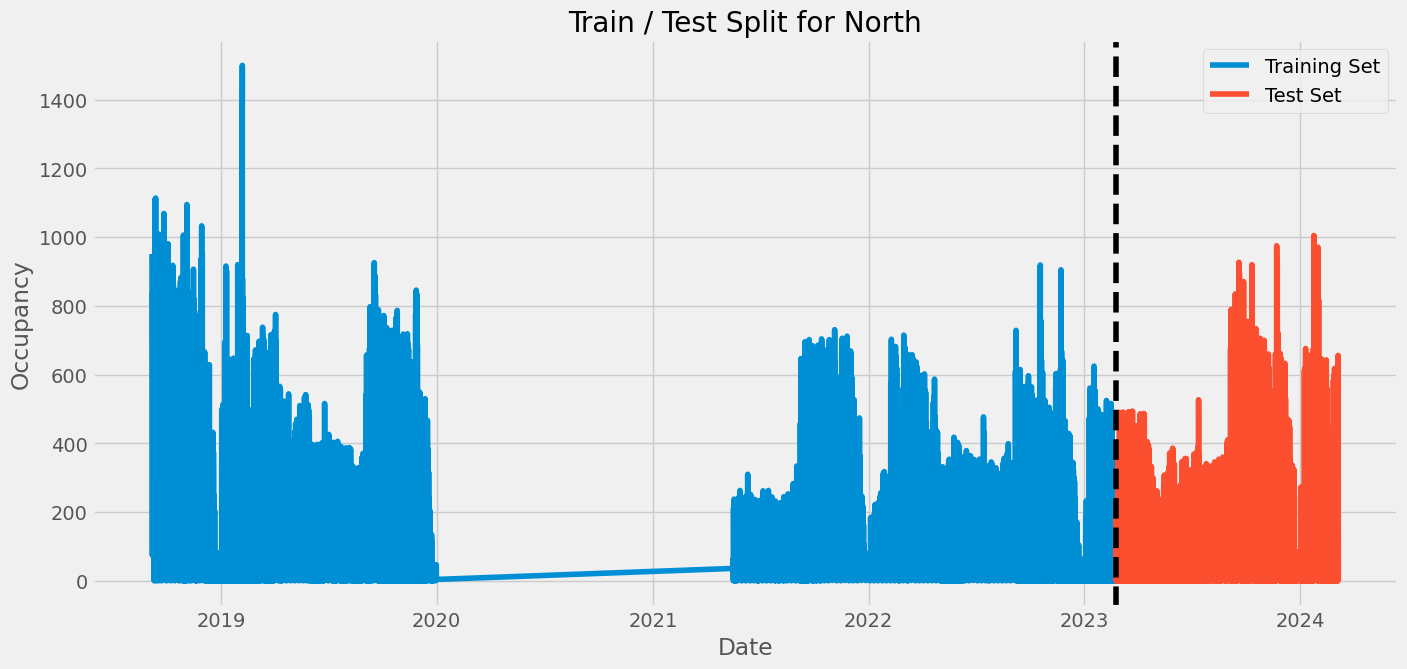

In [25]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
train_size = 0.75
train, test = train_test_split(df, test_size=(1 - train_size), shuffle=False)

# Plotting the data
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Occupancy'], label='Training Set')
plt.plot(test.index, test['Occupancy'], label='Test Set')
plt.axvline(test.index.min(), color='black', ls='--')
plt.title(f'Train / Test Split for {parking_lot_to_predict}')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.legend()
plt.show()


In [26]:
df

,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,...,sin_week,cos_week,sin_month,cos_month,is_day,is_weekend,month_of_year,quarter_of_year,day_duration,night_duration
date,,,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,951,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,2,0
2018-09-06 11:00:00,922,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,1,0
2018-09-06 12:00:00,833,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,0,0
2018-09-06 13:00:00,851,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,-1,0
2018-09-06 14:00:00,857,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,72,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,19
2024-03-05 20:00:00,10,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,20
2024-03-05 21:00:00,0,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,21


In [27]:
def add_lags(df):
    """
    Create time lags for added time series features and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Occupancy'].to_dict()
    """
    df['lag_1_hour'] = (df.index - pd.Timedelta('1 hours')).map(target_map)
    df['lag_2_hours'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    df['lag_3_hours'] = (df.index - pd.Timedelta('3 hours')).map(target_map)
    """
    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_30_days'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag_35_days'] = (df.index - pd.Timedelta('35 days')).map(target_map)
    df['lag_42_days'] = (df.index - pd.Timedelta('42 days')).map(target_map)
    df['lag_49_days'] = (df.index - pd.Timedelta('49 days')).map(target_map)
    df['lag_56_days'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag_60_days'] = (df.index - pd.Timedelta('60 days')).map(target_map)

     # Daily lags
    """
    for lag_days in range(1, 7):  # lags for 1 to 6 days
        df[f'lag_{lag_days}_days'] = (df.index - pd.Timedelta(f'{lag_days} days')).map(target_map)
    """
    return df

#df = add_lags(df)
df

,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,...,sin_week,cos_week,sin_month,cos_month,is_day,is_weekend,month_of_year,quarter_of_year,day_duration,night_duration
date,,,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,951,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,2,0
2018-09-06 11:00:00,922,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,1,0
2018-09-06 12:00:00,833,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,0,0
2018-09-06 13:00:00,851,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,-1,0
2018-09-06 14:00:00,857,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,72,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,19
2024-03-05 20:00:00,10,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,20
2024-03-05 21:00:00,0,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,21


In [28]:
df.columns

Index(['Occupancy', 'temp', 'visibility', 'dew_point', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h',
       'snow_1h', 'term_date', 'is_holiday', 'date', 'day_of_week', 'month',
       'day_of_year', 'hour', 'year', 'is_month_start', 'is_month_end',
       'sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month',
       'is_day', 'is_weekend', 'month_of_year', 'quarter_of_year',
       'day_duration', 'night_duration'],
      dtype='object')

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming df is your DataFrame and create_features is a function to generate features
train, test = train_test_split(df, test_size=(1-train_size), shuffle=False)

train = create_features(train)
test = create_features(test)
# Define the target variable and the column to exclude
TARGET = 'Occupancy'
EXCLUDE_COLUMNS = ['date', TARGET]

# Generate the list of features
FEATURES = [col for col in df.columns if col not in EXCLUDE_COLUMNS]
# weather features
# FEATURES = ['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'weather_Clear_sky is clear', 'weather_Clouds_broken clouds', 'weather_Clouds_few clouds', 'weather_Clouds_overcast clouds', 'weather_Clouds_scattered clouds', 'weather_Drizzle_drizzle', 'weather_Drizzle_light intensity drizzle', 'weather_Drizzle_light intensity drizzle rain', 'weather_Drizzle_rain and drizzle', 'weather_Dust_dust', 'weather_Fog_fog', 'weather_Haze_haze', 'weather_Mist_mist', 'weather_Rain_heavy intensity rain', 'weather_Rain_heavy intensity shower rain', 'weather_Rain_light intensity shower rain', 'weather_Rain_light rain', 'weather_Rain_moderate rain', 'weather_Rain_proximity shower rain', 'weather_Rain_shower rain', 'weather_Rain_very heavy rain', 'weather_Smoke_smoke', 'weather_Snow_heavy snow', 'weather_Snow_light rain and snow', 'weather_Snow_light shower sleet', 'weather_Snow_light shower snow', 'weather_Snow_light snow', 'weather_Snow_sleet', 'weather_Snow_snow', 'weather_Thunderstorm_thunderstorm', 'weather_Thunderstorm_thunderstorm with heavy rain', 'weather_Thunderstorm_thunderstorm with light rain', 'weather_Thunderstorm_thunderstorm with rain']


print(FEATURES)


['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'term_date', 'is_holiday', 'day_of_week', 'month', 'day_of_year', 'hour', 'year', 'is_month_start', 'is_month_end', 'sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'is_day', 'is_weekend', 'month_of_year', 'quarter_of_year', 'day_duration', 'night_duration']


In [30]:

'''
FEATURES = ['hour','day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days',
            'lag_1_hour', 'lag_2_hours', 'lag_3_hours',
            'lag_1_days', 'lag_2_days', 'lag_3_days', 'lag_4_days', 'lag_5_days','lag_6_days',
            ] + WEATHER_FEATURES

'''

TARGET = 'Occupancy'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        n_estimators=5000,
                        early_stopping_rounds=150,
                        objective='regression',
                        max_depth=5,
                        min_child_samples=1,
                        learning_rate=0.05,
                        colsample_bytree=0.91,
                        subsample=0.5,
                        reg_lambda=0.2)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_pred = reg.predict(X_test)

# Store actual and predicted values along with their datetime index in the DataFrame
actual_vs_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=test.index)


[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 27118, number of used features: 31
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150

In [31]:
actual_vs_pred_df.to_csv(f'lgb_{parking_lot_to_predict}_actual_vs_predicted.csv', index=True)

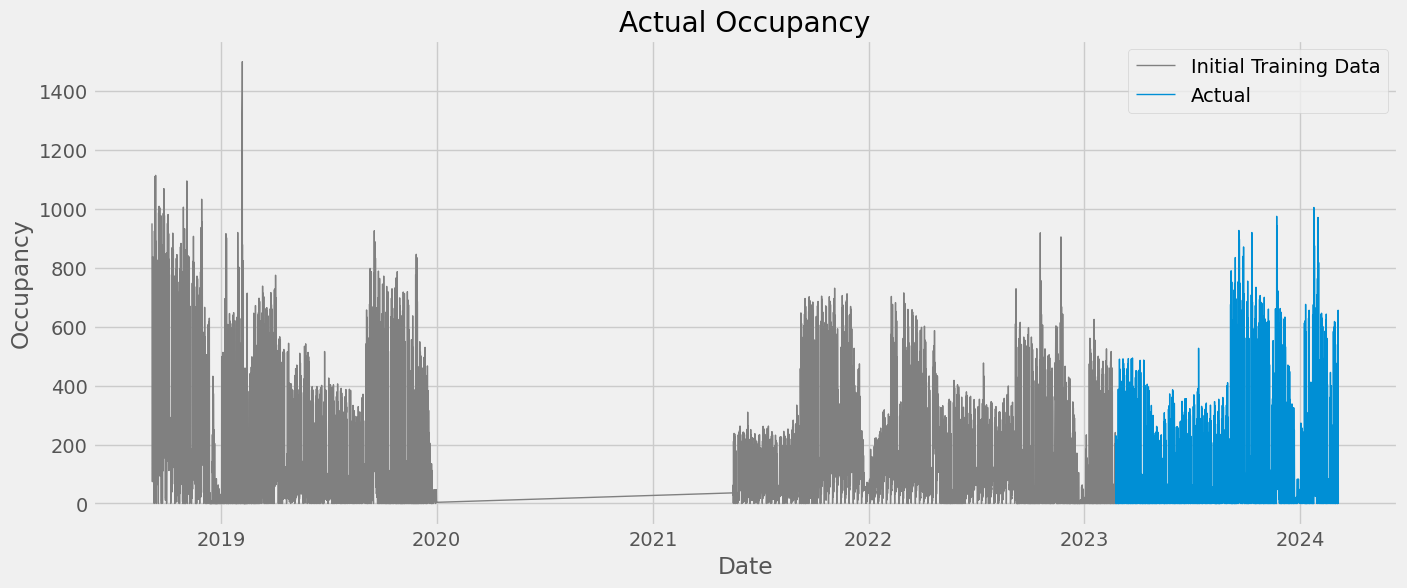

In [32]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train.index, train['Occupancy'], label='Initial Training Data', color='gray', linewidth=1)

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual', linewidth=1)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title('Actual Occupancy')

# Show legend
plt.legend()

# Show plot
plt.show()


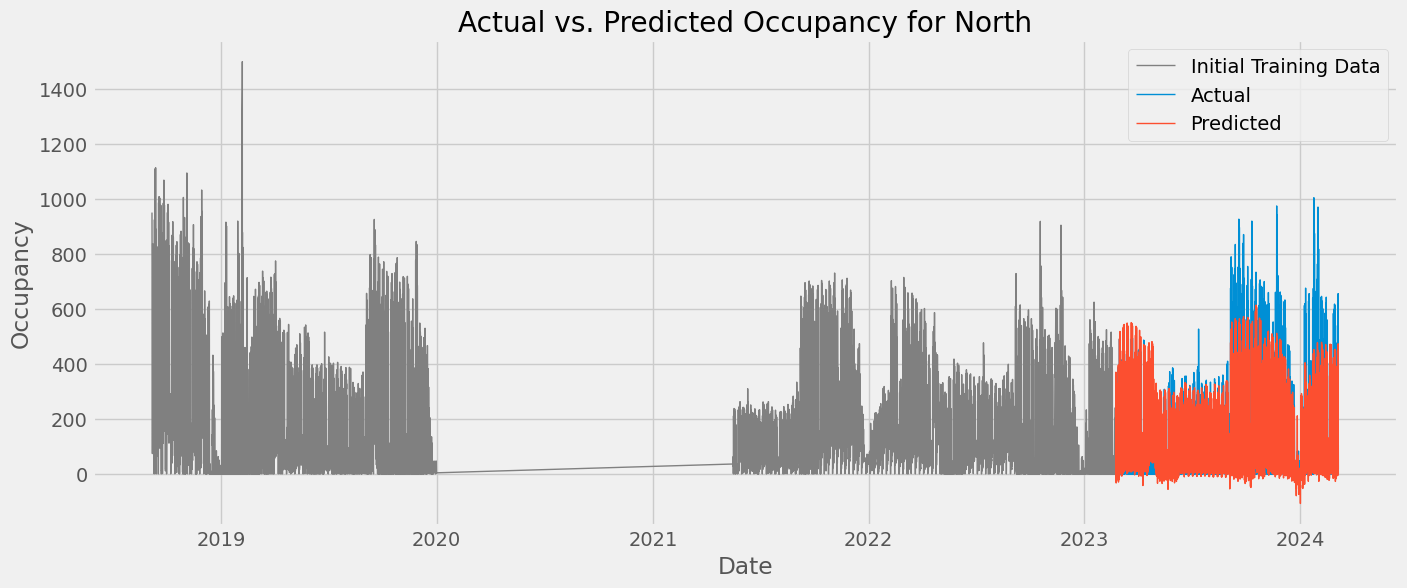

In [33]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train.index, train['Occupancy'], label='Initial Training Data', color='gray', linewidth=1)

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual', linewidth=1)
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted', linewidth=1)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title(f'Actual vs. Predicted Occupancy for {parking_lot_to_predict}')

# Show legend
plt.legend()

# Show plot
plt.show()


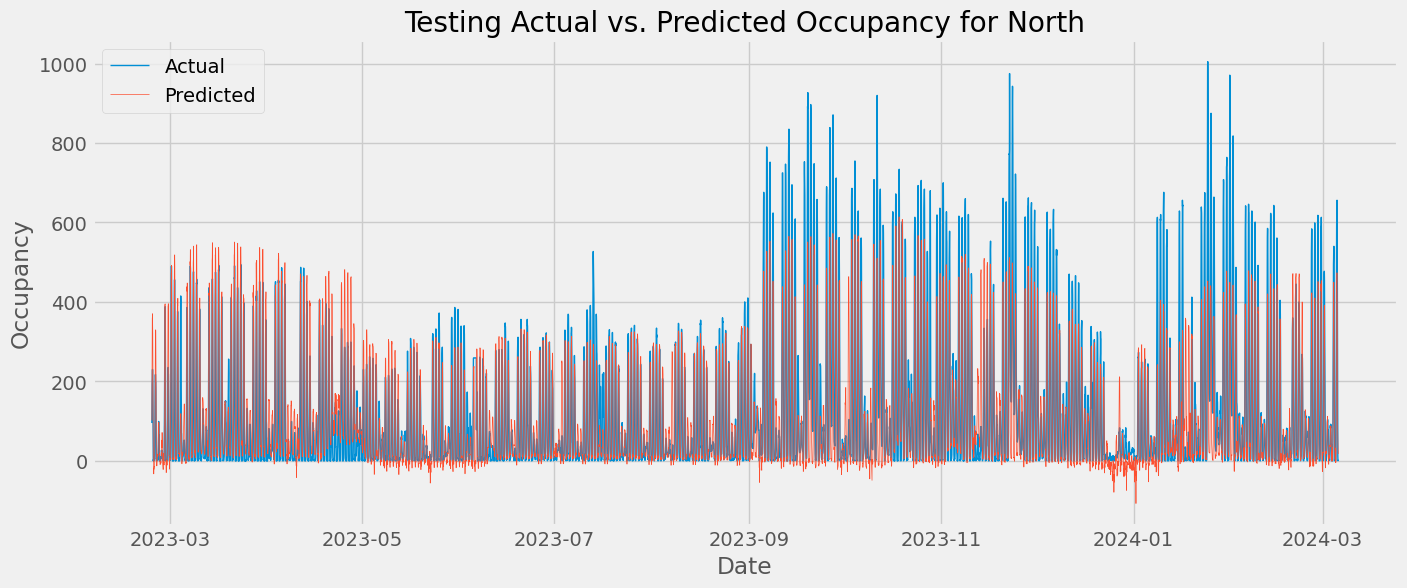

In [34]:
# Filter actual_vs_pred_df to include only the testing period
testing_actual_vs_pred_df = actual_vs_pred_df.loc[y_test.index]

# Create figure
plt.figure(figsize=(15, 6))

# Plot for the actual and predicted values during the testing period
plt.plot(testing_actual_vs_pred_df.index, testing_actual_vs_pred_df['Actual'], label='Actual', linewidth=1)
plt.plot(testing_actual_vs_pred_df.index, testing_actual_vs_pred_df['Predicted'], label='Predicted', linewidth=0.5)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title(f'Testing Actual vs. Predicted Occupancy for {parking_lot_to_predict}')

# Show legend
plt.legend()

# Show plot
plt.show()


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Extract actual and predicted values
actual_values = testing_actual_vs_pred_df['Actual']
predicted_values = testing_actual_vs_pred_df['Predicted']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values)

# Calculate R-squared
r2 = r2_score(actual_values, predicted_values)

print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)
print("R-squared:", r2)


RMSE: 77.33478828027333
MAE: 46.325430009835586
MSE: 5980.669478354701
R-squared: 0.80910034204526


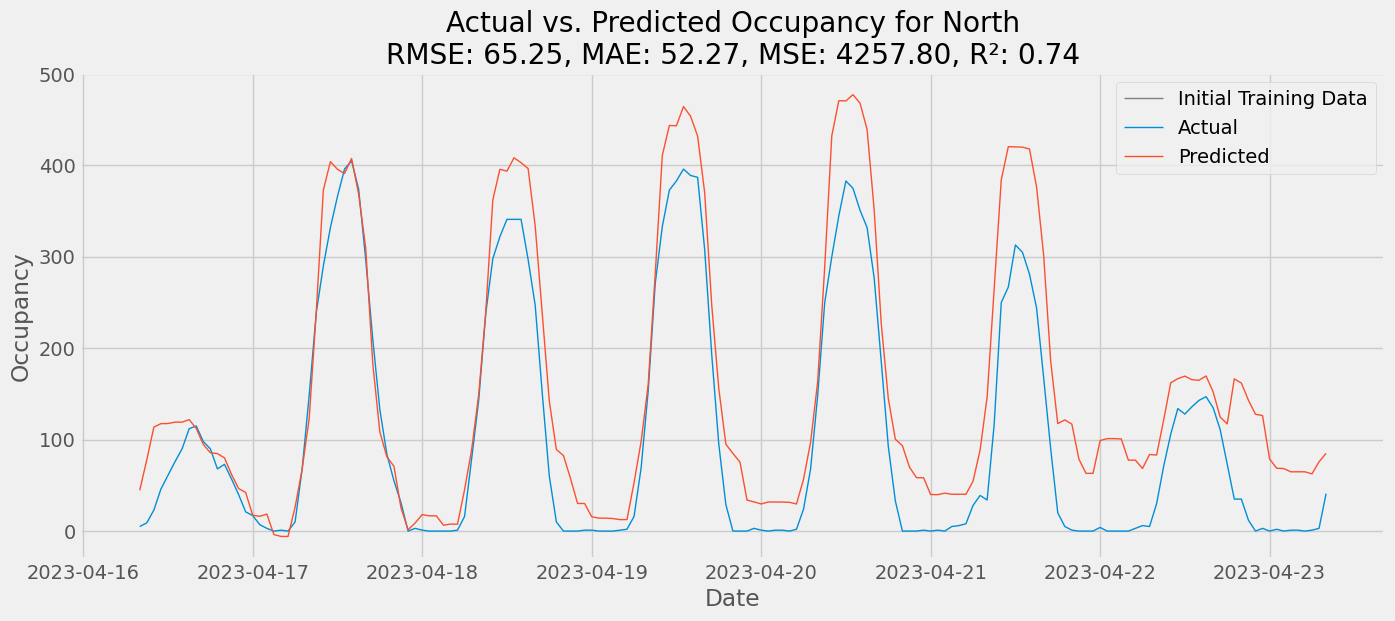

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure y_test has a DateTimeIndex
start_date = y_test.index.min()
end_date = y_test.index.max()

# Select a random start date within the y_test date range, ensuring there's room for 2 days after it
random_start_date = start_date + pd.to_timedelta(np.random.randint(0, (end_date - start_date).days - 1), unit='D')
random_end_date = random_start_date + pd.Timedelta(days=7)

# Filter the dataframes based on the 2-day range
train_filtered = train.loc[(train.index >= random_start_date) & (train.index <= random_end_date)]
actual_vs_pred_filtered = actual_vs_pred_df.loc[(actual_vs_pred_df.index >= random_start_date) & (actual_vs_pred_df.index <= random_end_date)]

# Ensure alignment of actual and predicted values
actual_vs_pred_filtered = actual_vs_pred_filtered.dropna(subset=['Actual', 'Predicted'])

# Calculate errors
actual = actual_vs_pred_filtered['Actual']
predicted = actual_vs_pred_filtered['Predicted']

mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train_filtered.index, train_filtered['Occupancy'], label='Initial Training Data', color='gray', linewidth=1)

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_filtered.index, actual_vs_pred_filtered['Actual'], label='Actual', linewidth=1)
plt.plot(actual_vs_pred_filtered.index, actual_vs_pred_filtered['Predicted'], label='Predicted', linewidth=1)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title(f'Actual vs. Predicted Occupancy for {parking_lot_to_predict}\n'
          f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}')

# Show legend
plt.legend()

# Show plot
plt.show()


In [37]:
actual_vs_pred_df.to_csv('west_actualvspred_longpred.csv')

In [38]:
actual_vs_pred_df

,Actual,Predicted
date,,
2023-02-23 08:00:00,95,101.552342
2023-02-23 09:00:00,153,216.220176
2023-02-23 10:00:00,192,333.244578
2023-02-23 11:00:00,206,359.507371
2023-02-23 12:00:00,221,360.997930
...,...,...
2024-03-05 19:00:00,72,75.932640
2024-03-05 20:00:00,10,59.853086
2024-03-05 21:00:00,0,39.630880


In [39]:
# Record the end time
end_time = time.time()

# Calculate the total run time
total_run_time = end_time - start_time
print("Total run time:", total_run_time, "seconds")

Total run time: 9.507891654968262 seconds


In [40]:
"""
# Retrain on all the data
df = create_features(df)

TARGET = 'Occupancy'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        n_estimators=5000,
                        early_stopping_rounds=150,
                        objective='regression',
                        max_depth=5,
                        min_child_samples=1,
                        learning_rate=0.05,
                        colsample_bytree=0.91,
                        subsample=0.5,
                        reg_lambda=0.2)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)])
"""

"\n# Retrain on all the data\ndf = create_features(df)\n\nTARGET = 'Occupancy'\n\nX_all = df[FEATURES]\ny_all = df[TARGET]\n\nreg = lgb.LGBMRegressor(boosting_type='gbdt',\n                        n_estimators=5000,\n                        early_stopping_rounds=150,\n                        objective='regression',\n                        max_depth=5,\n                        min_child_samples=1,\n                        learning_rate=0.05,\n                        colsample_bytree=0.91,\n                        subsample=0.5,\n                        reg_lambda=0.2)\n\nreg.fit(X_all, y_all, eval_set=[(X_all, y_all)])\n"

In [41]:
first_date_time = df.iloc[0]['date']
last_date_time = df.iloc[-1]['date']
#print(last_date_time)

new_date_time = last_date_time + pd.DateOffset(months=3)
#print(new_date_time)

first_date_time_str = first_date_time.strftime('%Y-%m-%d %H:%M:%S')
last_date_time_str = last_date_time.strftime('%Y-%m-%d %H:%M:%S')
new_date_time_str = new_date_time.strftime('%Y-%m-%d %H:%M:%S')
print(first_date_time_str)
print(last_date_time_str)
#print(new_date_time_str)

2018-09-06 10:00:00
2024-03-05 23:00:00


In [42]:
import pandas as pd

def update_features_for_date(df, date):
    """
    Create time series features for a specific date from the datetime index.
    """
    df['date'] = df.index
    
    # Create a dictionary to hold the new feature values for the specific date
    new_features = {}
    new_features['month'] = date.month
    new_features['day_of_year'] = date.dayofyear
    new_features['day_of_week'] = date.dayofweek
    new_features['hour'] = date.hour  # Add hour feature

    df['year'] = df['date'].dt.year
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # Seasonality features
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Seasonal indices (if applicable)
    # Autoregressive features (if applicable)
    # Time since last event (if applicable)
    # Day/night indicator
    df['is_day'] = np.where((df['hour'] >= 6) & (df['hour'] <= 18), 1, 0)
    
    # Weekend/weekday indicator
    df['is_weekend'] = df.date.dt.weekday // 4
    
    # Month of year
    df['month_of_year'] = df['date'].dt.month
    
    # Quarter of year
    df['quarter_of_year'] = df['date'].dt.quarter
    
    # Day/night duration
    df['day_duration'] = np.where(df['is_day'] == 1, 12 - df['hour'], 0)
    df['night_duration'] = np.where(df['is_day'] == 0, df['hour'], 0)

def update_rolling_features_for_date(df, date):
    df['date'] = df.index
    
    # Calculate the rolling window size and ensure we have enough data points
    window_size = 7  # 7-day rolling window
    past_window = df.loc[:date].tail(window_size)
    
    if len(past_window) < window_size:
        raise ValueError("Not enough data points in the past window to calculate rolling features.")
    
    new_features = {}
    # Rolling features based on past window
    new_features['rolling_min'] = float(past_window['Occupancy'].min())
    new_features['rolling_max'] = float(past_window['Occupancy'].max())
    new_features['rolling_sum'] = float(past_window['Occupancy'].sum())
    new_features['rolling_mean'] = float(past_window['Occupancy'].mean())
    new_features['rolling_median'] = float(past_window['Occupancy'].median())
    new_features['rolling_std'] = float(past_window['Occupancy'].std())
    new_features['rolling_quantile_25'] = float(past_window['Occupancy'].quantile(0.25))
    new_features['rolling_quantile_75'] = float(past_window['Occupancy'].quantile(0.75))
    
    # Update the DataFrame at the specific date index
    for feature, value in new_features.items():
        df.loc[date, feature] = value

In [43]:
def update_lags_for_date(df, date):
    """
    Create time lags for added time series features for a given date and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Occupancy'].to_dict()

    # Create a dictionary to hold the lag features for the specific date
    lag_features = {}
    """
    lag_features['lag_1_hour'] = float(target_map.get(date - pd.Timedelta('1 hours'), None))
    lag_features['lag_2_hours'] = float(target_map.get(date - pd.Timedelta('2 hours'), None))
    lag_features['lag_3_hours'] = float(target_map.get(date - pd.Timedelta('3 hours'), None))
    """

    lag_features['lag_7_days'] = float(target_map.get(date - pd.Timedelta('7 days'), None))
    lag_features['lag_14_days'] = float(target_map.get(date - pd.Timedelta('14 days'), None))
    lag_features['lag_21_days'] = float(target_map.get(date - pd.Timedelta('21 days'), None))
    lag_features['lag_28_days'] = float(target_map.get(date - pd.Timedelta('28 days'), None))
    lag_features['lag_30_days'] = float(target_map.get(date - pd.Timedelta('30 days'), None))
    lag_features['lag_35_days'] = float(target_map.get(date - pd.Timedelta('35 days'), None))
    lag_features['lag_42_days'] = float(target_map.get(date - pd.Timedelta('42 days'), None))
    lag_features['lag_49_days'] = float(target_map.get(date - pd.Timedelta('49 days'), None))
    lag_features['lag_56_days'] = float(target_map.get(date - pd.Timedelta('56 days'), None))
    lag_features['lag_60_days'] = float(target_map.get(date - pd.Timedelta('60 days'), None))

    """
    # Daily lags
    for lag_days in range(1, 7):  # lags for 1 to 6 days
        lag_features[f'lag_{lag_days}_days'] = float(target_map.get(date - pd.Timedelta(f'{lag_days} days'), None))
        """
    
    # Update the DataFrame at the specific date index
    for feature, value in lag_features.items():
        df.loc[date, feature] = value

# Example usage:
# date_time = pd.Timestamp('2023-12-14 22:00:00')  # Replace with your specific datetime
# updated_df = update_lags_for_date(something_df, date_time)

In [44]:
train_size = 0.75
new_train, new_test = train_test_split(df, test_size=(1 - train_size), shuffle=False)
old_test= new_test.copy()

# Define rolling calculation columns and time lag data columns to be cleaned
rolling_calculation_columns = [col for col in new_test.columns if 'rolling' in col]  # Example: Identify rolling calculation columns
time_lag_columns = [col for col in new_test.columns if 'lag' in col]  # Example: Identify time lag data columns
occupancy_column = [col for col in new_test.columns if 'Occupancy' in col]  # Example: Identify occupancy data columns

# Iterate over rolling calculation columns and set data to NaN
for col in rolling_calculation_columns:
    new_test[col] = np.nan

# Iterate over time lag data columns and set data to NaN
for col in time_lag_columns:
    new_test[col] = np.nan

# Iterate over occupancy columns and set data to NaN
for occ in occupancy_column:
    new_test[occ] = np.nan

something_df = pd.concat([new_train, new_test])

In [45]:
start_ind_time = new_train.iloc[-1]['date']
end_ind_time = new_test.iloc[-1]['date']

print(start_ind_time, end_ind_time)

2023-02-23 07:00:00 2024-03-05 23:00:00


In [46]:
# Select data between rand_date_time and last_date_time
selected_data = something_df.loc[(something_df.index > start_ind_time) & (something_df.index <= end_ind_time)]
selected_data

,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,...,sin_week,cos_week,sin_month,cos_month,is_day,is_weekend,month_of_year,quarter_of_year,day_duration,night_duration
date,,,,,,,,,,,,,,,,,,,,,
2023-02-23 08:00:00,NaN,-2.45,10000.0,-5.38,-9.16,1006,78,7.20,100,NaN,...,0.433884,-0.900969,0.866025,5.000000e-01,1,0,2,1,4,0
2023-02-23 09:00:00,NaN,-2.59,10000.0,-8.92,-9.34,1006,58,7.20,100,NaN,...,0.433884,-0.900969,0.866025,5.000000e-01,1,0,2,1,3,0
2023-02-23 10:00:00,NaN,-2.59,10000.0,-11.53,-9.59,1007,46,10.29,100,NaN,...,0.433884,-0.900969,0.866025,5.000000e-01,1,0,2,1,2,0
2023-02-23 11:00:00,NaN,-2.45,10000.0,-12.15,-9.45,1007,43,10.80,100,NaN,...,0.433884,-0.900969,0.866025,5.000000e-01,1,0,2,1,1,0
2023-02-23 12:00:00,NaN,-2.45,10000.0,-13.51,-9.45,1007,38,11.32,100,NaN,...,0.433884,-0.900969,0.866025,5.000000e-01,1,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,NaN,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,...,0.781831,0.623490,1.000000,6.123234e-17,0,0,3,1,0,19
2024-03-05 20:00:00,NaN,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,...,0.781831,0.623490,1.000000,6.123234e-17,0,0,3,1,0,20
2024-03-05 21:00:00,NaN,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,...,0.781831,0.623490,1.000000,6.123234e-17,0,0,3,1,0,21


In [47]:
date_time = selected_data.iloc[0]["date"]
print(date_time)

2023-02-23 08:00:00


In [48]:
"""
# Create a date range from last_date_time to new_date_time
date_range = pd.date_range(start=start_ind_time, end=end_ind_time, freq='H')  # 'D' represents day frequency
for date_time in date_range:
    
    update_features_for_date(something_df, date_time)
    #update_rolling_features_for_date(something_df, date_time)
    #update_lags_for_date(something_df, date_time)

        # Assuming 'row_data' contains the data for the single row you want to predict
        # 'row_data' should be a pandas Series or DataFrame with the same columns as your training data
    row_data = something_df[something_df.index == date_time].iloc[0]  # Example: selecting the first row from the test data
        # List of features to exclude
    features_to_exclude = ["Occupancy", "date"]  # Add the names of features you want to exclude

        # Filtering out excluded features
    filtered_row_data = row_data.drop(features_to_exclude, inplace=False)  # inplace=False ensures row_data remains unchanged

        # Extracting the features from the filtered row data
    X_single = filtered_row_data[FEATURES].values.reshape(1, -1)  # Reshaping to a 2D array as expected by the model

    filtered_row_data = pd.DataFrame([filtered_row_data])
    predicted_occupancy = reg.predict(filtered_row_data)
        # Extract the predicted occupancy value from the array
    predicted_occupancy_value = predicted_occupancy[0]

    print(predicted_occupancy_value)

        # Assign predicted occupancy to the 'Occupancy' column of the row with index 'last_date_time'
    something_df.loc[date_time, 'Occupancy'] = predicted_occupancy_value
    row_data = something_df[something_df.index == date_time].iloc[0]
"""

'\n# Create a date range from last_date_time to new_date_time\ndate_range = pd.date_range(start=start_ind_time, end=end_ind_time, freq=\'H\')  # \'D\' represents day frequency\nfor date_time in date_range:\n    \n    update_features_for_date(something_df, date_time)\n    #update_rolling_features_for_date(something_df, date_time)\n    #update_lags_for_date(something_df, date_time)\n\n        # Assuming \'row_data\' contains the data for the single row you want to predict\n        # \'row_data\' should be a pandas Series or DataFrame with the same columns as your training data\n    row_data = something_df[something_df.index == date_time].iloc[0]  # Example: selecting the first row from the test data\n        # List of features to exclude\n    features_to_exclude = ["Occupancy", "date"]  # Add the names of features you want to exclude\n\n        # Filtering out excluded features\n    filtered_row_data = row_data.drop(features_to_exclude, inplace=False)  # inplace=False ensures row_data re

In [49]:
"""
something_df
# Select data between rand_date_time and last_date_time
selected_data = something_df.loc[(something_df.index > start_ind_time) & (something_df.index <= end_ind_time)]
selected_data
"""

'\nsomething_df\n# Select data between rand_date_time and last_date_time\nselected_data = something_df.loc[(something_df.index > start_ind_time) & (something_df.index <= end_ind_time)]\nselected_data\n'

In [50]:
"""
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

num_count = 3

# Select data between start_ind_time and start_ind_time_a
selected_data = something_df.loc[(something_df.index >= date_time) & (something_df.index <= date_time + pd.DateOffset(months = num_count))]
old_test_formatted = old_test.loc[(old_test.index >= date_time) & (old_test.index <= date_time + pd.DateOffset(months = num_count))]

# Plot the 'Occupancy' column
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(old_test_formatted.index, old_test_formatted['Occupancy'], linestyle='-', linewidth=0.2, color='blue', label='Old Test')
plt.plot(selected_data.index, selected_data['Occupancy'], linestyle='-', linewidth=0.2, color='red', label='Selected Data')

# Format the x-axis with date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title('Occupancy between {} and {}'.format(start_ind_time, date_time + pd.DateOffset(weeks = 1)))
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()
"""


"\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\n\nnum_count = 3\n\n# Select data between start_ind_time and start_ind_time_a\nselected_data = something_df.loc[(something_df.index >= date_time) & (something_df.index <= date_time + pd.DateOffset(months = num_count))]\nold_test_formatted = old_test.loc[(old_test.index >= date_time) & (old_test.index <= date_time + pd.DateOffset(months = num_count))]\n\n# Plot the 'Occupancy' column\nplt.figure(figsize=(10, 6))  # Adjust size as needed\nplt.plot(old_test_formatted.index, old_test_formatted['Occupancy'], linestyle='-', linewidth=0.2, color='blue', label='Old Test')\nplt.plot(selected_data.index, selected_data['Occupancy'], linestyle='-', linewidth=0.2, color='red', label='Selected Data')\n\n# Format the x-axis with date format\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))\nplt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())\n\nplt.title('Occupancy between {} and {}'.format(start_

In [51]:
# Get feature importances
feature_importances = reg.feature_importances_

# Get feature names
feature_names = reg.feature_name_

# Print feature importances and names
for name, importance in zip(feature_names, feature_importances):
    print(name, ":", importance)


temp : 191
visibility : 18
dew_point : 218
feels_like : 90
pressure : 190
humidity : 137
wind_speed : 75
clouds_all : 41
rain_1h : 50
snow_1h : 11
term_date : 1
is_holiday : 97
day_of_week : 333
month : 32
day_of_year : 503
hour : 569
year : 546
is_month_start : 4
is_month_end : 3
sin_day : 421
cos_day : 257
sin_week : 126
cos_week : 59
sin_month : 48
cos_month : 19
is_day : 137
is_weekend : 0
month_of_year : 1
quarter_of_year : 0
day_duration : 150
night_duration : 27


In [52]:
feature_importances = reg.feature_importances_

# Create a DataFrame to store the feature importances
feature_importance = pd.DataFrame(data=feature_importances, index=X_train.columns, columns=['importance'])

# Print the DataFrame
print(feature_importance)

                 importance
temp                    191
visibility               18
dew_point               218
feels_like               90
pressure                190
humidity                137
wind_speed               75
clouds_all               41
rain_1h                  50
snow_1h                  11
term_date                 1
is_holiday               97
day_of_week             333
month                    32
day_of_year             503
hour                    569
year                    546
is_month_start            4
is_month_end              3
sin_day                 421
cos_day                 257
sin_week                126
cos_week                 59
sin_month                48
cos_month                19
is_day                  137
is_weekend                0
month_of_year             1
quarter_of_year           0
day_duration            150
night_duration           27


In [53]:
X_train.columns

Index(['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity',
       'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'term_date',
       'is_holiday', 'day_of_week', 'month', 'day_of_year', 'hour', 'year',
       'is_month_start', 'is_month_end', 'sin_day', 'cos_day', 'sin_week',
       'cos_week', 'sin_month', 'cos_month', 'is_day', 'is_weekend',
       'month_of_year', 'quarter_of_year', 'day_duration', 'night_duration'],
      dtype='object')

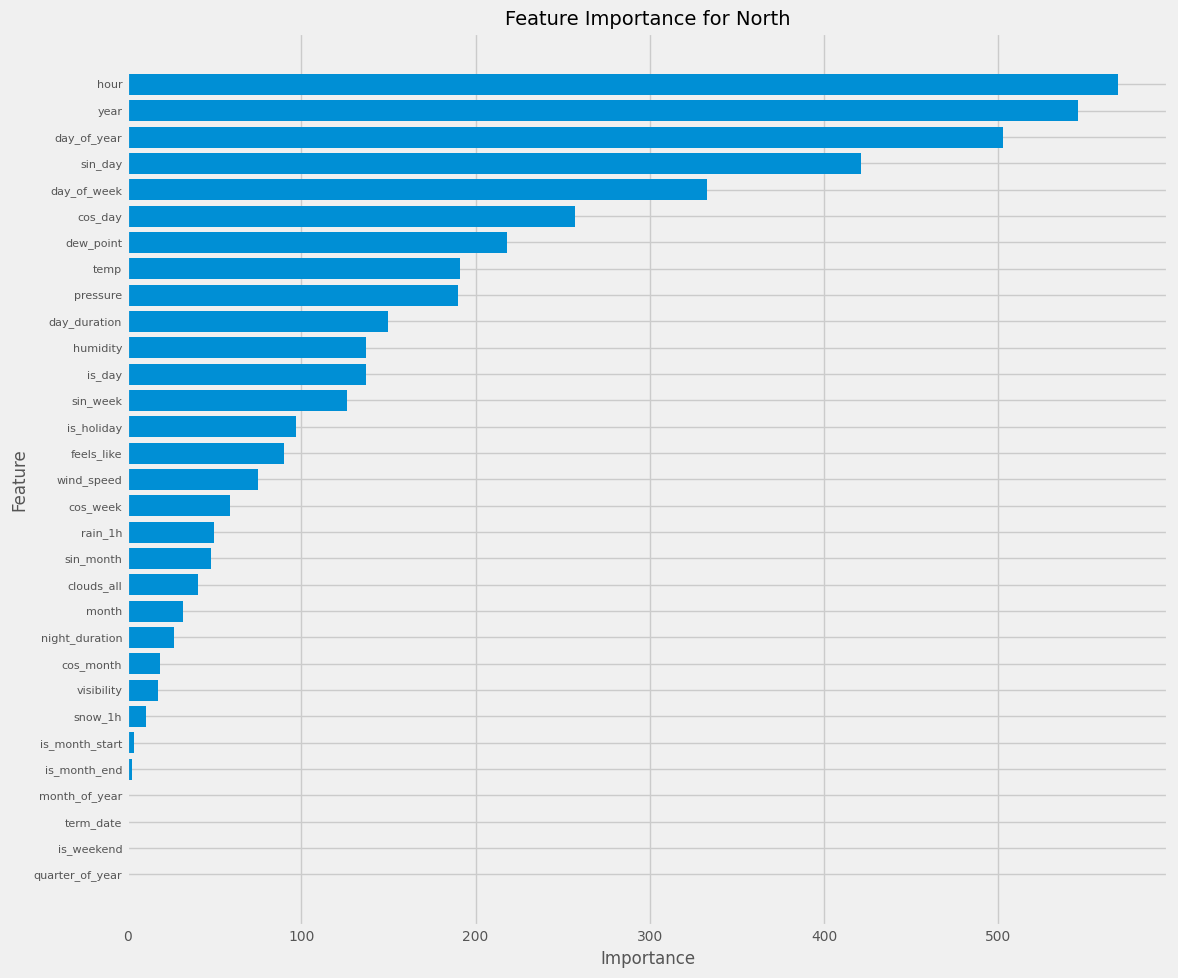

In [54]:
import matplotlib.pyplot as plt

# Sort the feature importances in ascending order
sorted_feature_importance = feature_importance.sort_values('importance')

# Plot the sorted feature importances
plt.figure(figsize=(12, 10))
barplot = plt.barh(sorted_feature_importance.index, sorted_feature_importance['importance'])

# Adjust font size for each y-axis label individually
for tick in plt.gca().get_yticklabels():
    tick.set_fontsize(8)

plt.xlabel('Importance', fontsize=12)  # Adjust font size for x-label
plt.ylabel('Feature', fontsize=12)  # Adjust font size for y-label
plt.title(f'Feature Importance for {parking_lot_to_predict}', fontsize=14)  # Adjust font size for title
# Adjust font size for x-axis ticks
plt.xticks(fontsize=10)

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
